# Entrega FEM 2D 
### Ferreyra, Marcos J. (29554)

Actividad 4: Actividad para introducción al método de elementos finitos en 2D

1- Realice la siguiente pieza en un script de Gmsh. No es necesario que las puntas sean redondeadas. 

2- Exporte la malla para ser utilizada en FEniCS, tal como lo hicimos en el siguiente link(https://github.com/rirastorza/Intro2FEM/blob/master/Elementos_finitos_en_2D/termico2D.ipynb).

3- Desarrolle el script en FEniCS para computar el desplazamiento, deformación y esfuerzo de la pieza 
(es un problema elástico estático, tal como lo hicimos en el siguiente link:https://github.com/rirastorza/Intro2FEM/blob/master/Elementos_finitos_en_2D/ElasticidadLineal2D.ipynb). 
Note que debe imponer condiciones de borde de Dirichlet en los puntos fijados a la pared (Two bolts) y de Neumann en donde 
está aplicada la fuerza W (Pin) (recuerde las condiciones de borde en el siguiente link: https://github.com/rirastorza/Intro2FEM/blob/master/Elementos_finitos_en_1D/mecanica1D.ipynb). 
Compare con la solución descripta en la referencia, que es un modelo de 1D considerando deformaciones de corte (Ec.1.2 de la separata subida: https://frlp.cvg.utn.edu.ar/pluginfile.php/39472/mod_book/chapter/23/separata.pdf).




[1] Klaus-Jürgen Bathe, “Finite Element procedures (second edition)”, (2016).


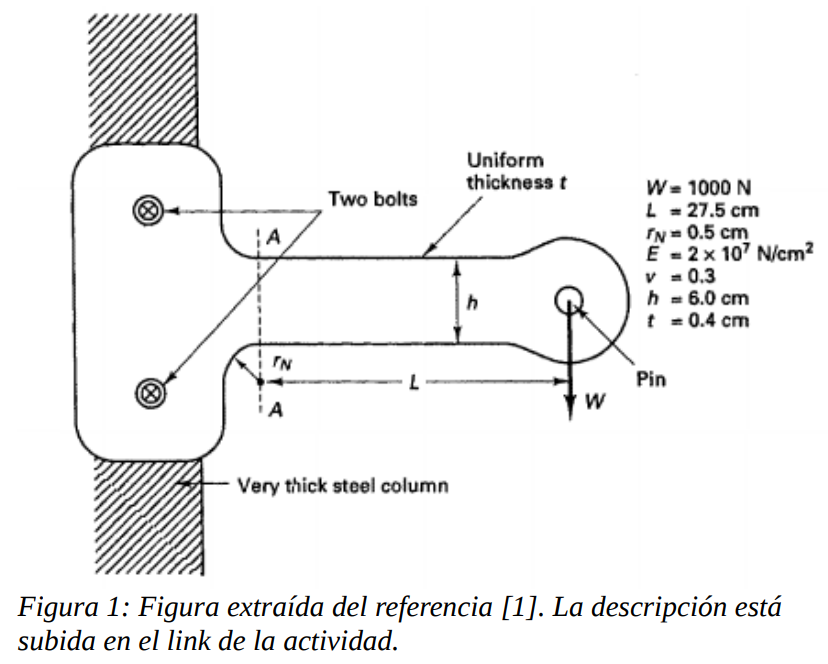

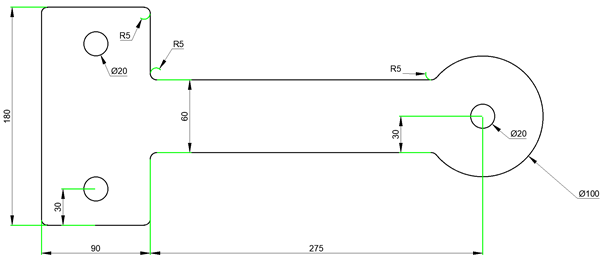

**Parámetros en GMSH:**
(En el dibujo las cotas se encuentran en mm mientras que en el Script están en cm)

//Parameters

gridsize = 1.0;

h = 18; //Height

r_curv = 0.5; //Edges Radius

w = 9; //Width

h_c = 6; //Cantilever Height

a = 27.5; //Cantilever Long

L = a+w; //Distance to the applied force

R = 5; //Biggest Circle Radius

r_h = 1; //Holes Radius

h_h = 3; //Holes Height

l = L-R*Sqrt(1-(h_c/(2*R))^2); //Distance to the joint between cantilever and the biggest circle


Una vez realizada la geometría y su malla en Gmsh se la importa a Fenics. Sin embargo, antes debemos generar tres archivos a partir del archivo .msh (exportado como VERSION 2 ASCII): pieza.xml, pieza_physical_region.xml, y pieza_facet_region.xml, que contienen la malla, las marcas de las regiones físicas, y las marcas de las fronteras o bordes. Hemos escrito todas estas instrucciones utilizando la herramienta de Python *os* que toma el sistema operativo y ejecuta los comandos que se le pasan como string. Por ejemplo: la primer instrucción por consola *dolfin-convert pieza.msh pieza.xml* la podemos escribir en un script de Python como vemos a continuación. Sumado a eso definimos identificamos los subdominios y los marcadores de borde en el dominio de trabajo. 

In [45]:
import os
string = "dolfin-convert pieza.msh pieza.xml"
os.system(string)
from fenics import *

mesh = Mesh("pieza.xml");
subdomains = MeshFunction('size_t',mesh,"pieza_physical_region.xml");
boundary_markers = MeshFunction('size_t',mesh,"pieza_facet_region.xml");
ds = Measure('ds', domain=mesh, subdomain_data=boundary_markers)

En primer lugar debemos tener en cuenta que este análisis se realizará bajo un régimen estático considerando pequeñas deformaciones a lo largo de la pieza. Procedemos a definir las constantes del material y los parámetros de Lamé. Cómo el procedimiento en 3D es análogo que el 2D Tensiones Planas (Plane Stress) solo que se modifica ligeramente la ley constitutiva agregamos un operador 'if': 

[**Parámetros de Lamé**](https://es.wikipedia.org/wiki/Par%C3%A1metros_de_Lam%C3%A9):

$$\mu = \frac{E}{2\left(1+\nu\right)}\\
\lambda = \frac{E\nu}{\left(1+\nu\right)\left(1-2\nu\right)}\tag{1}$$

donde $E$ es el módulo de Young y $\nu$ es el coeficiente de Poisson. Ambos se consideran constantes en todo el material en todas las direcciones. Esta expresión también puede encontrarse en función de la deformación:

$$\sigma = 2\mu\varepsilon\left(u\right)+\lambda tr\left(\varepsilon\left(u\right)\right) I \tag{2}$$

En el caso de 2D Tensiones Planas la tensión en $z$ será nula, pero la deformación que sale del plano no lo será. Se puede demostrar que $\varepsilon_{zz}= - \frac{\lambda}{\lambda+2\mu}\left(\varepsilon_{xx}+\varepsilon_{yy}\right)$. Si introducimos esto en la segunda expresión de la Ec. (2) se tiene:

$$\sigma = \lambda^{*} tr\left(\varepsilon\right) I +2\mu\varepsilon$$

que es una expresión similar al caso general 3D donde se modifica el coeficiente de Lamé $\lambda$ por $\lambda^{*}= \frac{2\lambda \mu}{\lambda+2\mu}$.


Llegando al final del bloque definimos las expresiones de la tensión y deformación:


$$\varepsilon = \frac{1}{2} \left( \nabla u + \nabla u^{T} \right)$$
 
    

In [46]:
E = Constant(2e7)                                        #Young's Modulus [N/cm2]
nu = Constant(0.3)                                       #Poisso's Ratio [Adim]
mu = E/2/(1+nu)                                          #Shear Modulus [Adim]
lmbda = E*nu/(1+nu)/(1-2*nu)                             #1st Lamé Parameter [Adim]
model = "plane_stress"
if model == "plane_stress":
    lmbda = 2*mu*lmbda/(lmbda+2*mu)                      #Lambda* [Adim]

def eps(v):                                              #Deformation Epsilon [Adim]
    return 0.5*(nabla_grad(v) + nabla_grad(v).T)
def sigma(v):                                            #Stress [N/cm2]
    return lmbda*tr(eps(v))*Identity(2) + 2.0*mu*eps(v)  

Como es un problema en un espacio vectorial, definiremos un espacio de funciones de características vectoriales. A su vez definiremos las condiciones de borde de froma vectorial:

In [117]:
V = VectorFunctionSpace(mesh, 'Lagrange', degree=2)      #Espacio de funciones vectorial

dis = Constant((0.,0.))                                  #Condición de borde de desplazamiento en los tornillos-> VECTOR
w = Constant((0.,-1000.))                                #Fuerza W [N] en dirección vertical negativa -> VECTOR


Definimos las funciones Test, Trial y f. Todas ellas también de forma vectorial:

In [118]:
rho_g = (9.81*0.00785)                                   #Peso específico del acero en N/cm3
f = Constant((0,-rho_g))                                 #La 'body force', en este caso el peso
u = TrialFunction(V)                                      
v = TestFunction(V)                                      

Armo un diccionario donde se encuentran las condiciones de borde con sus respectivos valores. Para luego clasificarlas con una función if y almacernarlos en listas. Las condiciones de borde a aplicar son:

A- Condiciones de **Dirichlet** en las regiones **10** y **20**, las cuales son los tornillos afirmado a la columna de acero. Consideraremos que su desplazamiento *u* es constante y nulo en dichas regiones.

B- Condiciones de **Neumann** en la región **30** la cual es el orificio del extremo en el voladizo. Al estar aplicando una Fuerza W de manera constante en dicho sitio, la derivada del desplazamiento, o sea la deformación, será constante.

In [119]:
boundary_conditions = {10: {'Dirichlet': dis},           #
                       20: {'Dirichlet': dis},           #Diccionario con las BC
                       30: {'Neumann': w}}               #
bc_dirichlet = []                                        #Lista de Dirichlet BC
for i in boundary_conditions:
    if 'Dirichlet' in boundary_conditions[i]:
        bc = DirichletBC(V, boundary_conditions[i]['Dirichlet'], boundary_markers, i)
        bc_dirichlet.append(bc)

bc_neumann = []                                          #Lista de Neumann BC
for i in boundary_conditions:
    if 'Neumann' in boundary_conditions[i]:
        g =  boundary_conditions[i]['Neumann']
        bc_neumann.append(inner(w,v)*ds(i))

Por último nos queda introducir la ecuación obtenida a traves de la Formulación Variacional del problema:
$$ F = \int_{\Omega} \sigma \cdot \varepsilon_{v} \ dx - \int_{\partial \Omega} v \cdot \left(\sigma \cdot n\right) \ ds - \int_{\Omega} f\cdot v \ dx $$
Podemos observar tres términos en el miembro derecho de la ecuación. Sin entrar en detalles, el primero se encuentra asociado a la energía de deformación, el segundo a las fuerzas externas y el tercero a las fuerzas dentro del cuerpo o dominio. 

In [120]:
F = inner(sigma(u), eps(v))*dx - sum(bc_neumann) - inner(f, v)*dx  #Weak Form
a = lhs(F)
L = rhs(F)

#Solution
u = Function(V, name="Desplazamiento")
solve(a == L, u, bc_dirichlet)

Una vez resuelta, procedemos a graficar y a evaluar el desplazamiento máximo y las tensiones según el criterio de Von Mises

Desplazamiento máximo:  0.03727 [cm]


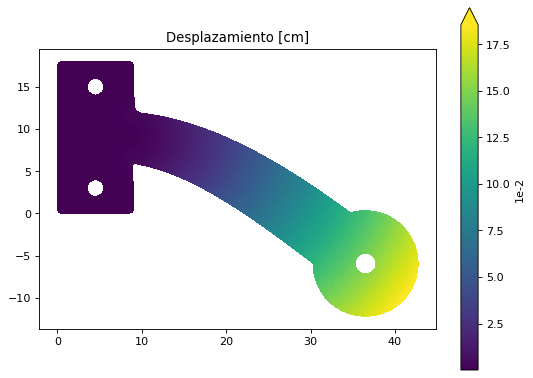

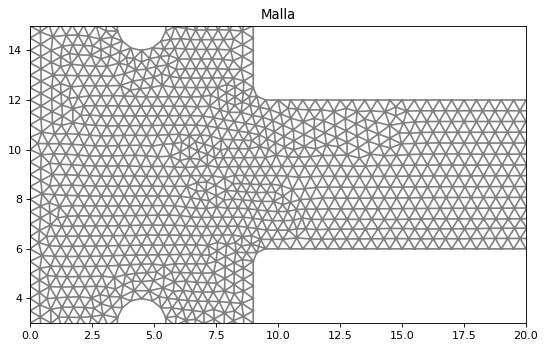

In [124]:
import matplotlib.pyplot as plt
plt.figure(1,figsize=(8, 6), dpi=80)
im = plot(1e2*u,mode="displacement",title='Desplazamiento [cm]')
plt.colorbar(im, extend= 'max', label = '1e-2')
plt.figure(2,figsize=(8, 6), dpi=80)
plot(mesh,title='Malla')
plt.axis([0, 20, 3, 15])

uh = u.compute_vertex_values(mesh) 
desplazamiento_max = max(uh)
print('Desplazamiento máximo: ', round(desplazamiento_max,5),'[cm]')

[Von Mises](https://es.wikipedia.org/wiki/Tensi%C3%B3n_de_Von_Mises). La expresión de la tensión de von Mises es:

$$\sigma_{M} = \sqrt{\frac{3}{2} s : s}$$

donde $s=\sigma -\frac{1}{3} tr \left(\sigma\right) I$.

Tensión máxima de Von Mises:  414.976 [N/cm2]


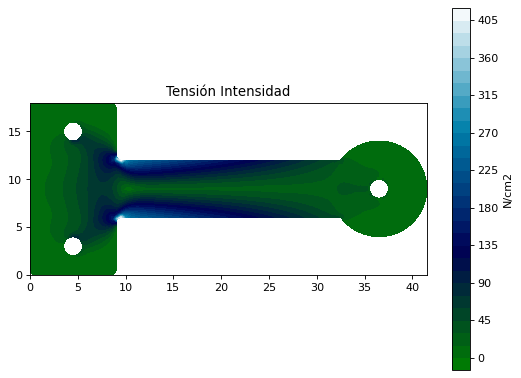

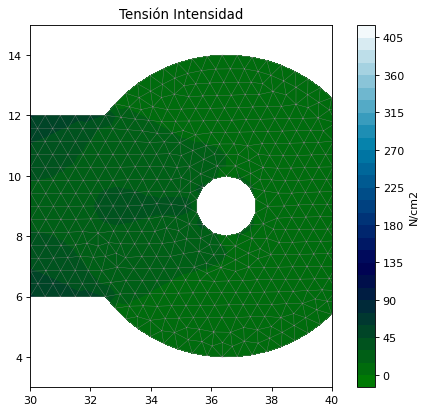

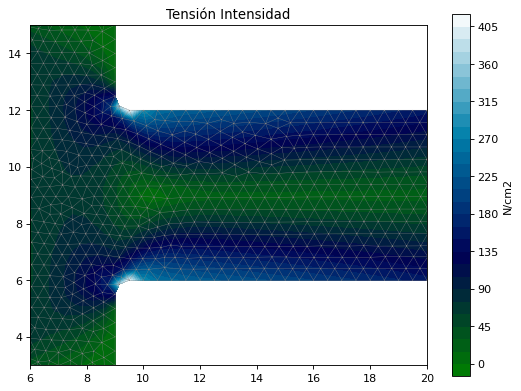

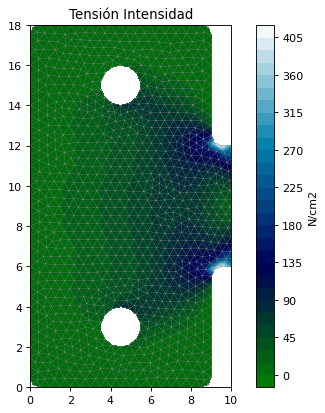

In [133]:
s = sigma(u) - (1./3)*tr(sigma(u))*Identity(2)
von_Mises = sqrt(3./2*inner(s, s))/100
V = FunctionSpace(mesh, 'P', 1)
von_Mises = project(von_Mises, V)


plt.figure(3,figsize=(8, 6), dpi=80)
im0 = plot(von_Mises, title='Tensión Intensidad',cmap="ocean")
plt.colorbar(im0, label = 'N/cm2')


plt.figure(4,figsize=(8, 6), dpi=80)
im1 = plot(von_Mises,title='Tensión Intensidad',cmap="ocean")
plot(mesh, linewidth=0.3)
plt.axis([30, 40, 3, 15])
plt.colorbar(im1, label = 'N/cm2')


plt.figure(5,figsize=(8, 6), dpi=80)
im2 = plot(von_Mises, title='Tensión Intensidad',cmap="ocean")
plot(mesh, linewidth=0.3)
plt.axis([6, 20, 3, 15])
plt.colorbar(im2, label = 'N/cm2')


plt.figure(6,figsize=(8, 6), dpi=80)
im3 = plot(von_Mises, title='Tensión Intensidad',cmap="ocean")
plot(mesh, linewidth=0.3)
plt.axis([0, 10, 0, 18])
plt.colorbar(im3, label = 'N/cm2')

tensionVM_max = max(von_Mises.vector())
print('Tensión máxima de Von Mises: ',round(tensionVM_max,3),'[N/cm2]')